**CITY OF TUCSON'S CLIMATE ACTION AND ADAPTATION PLAN COMMUNITY SURVEY**
---

*Questions to analyze:*

- Do you have other climate mitigation ideas? Submit here:
- Do you have other climate adaptation ideas? Submit here:
- Do you have other ideas for environmental equity, justice, and community resilience? Submit here:
- Do you have other policy ideas? Submit here:
- Are you interested in participating in any other ways to help make Tucson environmentally sustainable? Submit here:
- Is there anything else you would like to share that was not already addressed?

# Código base

## Librerías

In [1]:
import numpy as np
from numpy import mean
import pandas as pd
from sklearn import model_selection, preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict, RepeatedStratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, SGDClassifier
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


In [2]:
plt.style.use('dark_background')

In [3]:
random_state = 100

## Utilidades

In [4]:
def sample(df: pd.DataFrame, model, oversample: bool = False, undersample: bool = False):
    X = df.values[:, 3:]
    y = df.values[:, 1]
    steps = []

    if oversample:
        steps.append(('over', RandomOverSampler(random_state=random_state)))

    if undersample:
        steps.append(('under', RandomUnderSampler(random_state=random_state)))

    steps.append(('model', model))

    pipeline = Pipeline(steps=steps)

    cv = RepeatedStratifiedKFold(
        n_splits=10,
        n_repeats=4,
        random_state=random_state
    )

    scoring = {
        "AUC": "roc_auc",
        "Accuracy": make_scorer(accuracy_score),
        "Recall": make_scorer(recall_score, pos_label='Positive'),
        "Precision": make_scorer(precision_score, pos_label='Positive'),
        "F1": "f1_micro",
    }

    scores = cross_validate(
        pipeline,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=-1
    )

    print(f'AUC: {mean(scores["test_AUC"])}')
    print(f'Accuracy: {mean(scores["test_Accuracy"])}')
    print(f'Recall: {mean(scores["test_Recall"])}')
    print(f'Precision: {mean(scores["test_Precision"])}')
    print(f'F1: {mean(scores["test_F1"])}')


In [5]:
def read_dataset(filename: str, encoding: str = 'utf-8', separator=',') -> pd.DataFrame:
    df = pd.read_csv(filename, encoding=encoding, sep=separator)
    print('Dataset leido.')
    return df

In [6]:
def encode_labels(df: pd.DataFrame, col_index: int) -> pd.DataFrame:
    le = preprocessing.LabelEncoder()
    df.values[:, col_index] = le.fit(df.values[:, col_index])
    return df

In [7]:
def split_dataset(df: pd.DataFrame) -> tuple:
    X = df.values[:, 3:]
    y = df.values[:, 1]
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=0.3, random_state=100)
    print('Dataset dividido.')
    return X_train, X_test, y_train, y_test

In [8]:
def predict(X_test, model):
    y_pred = model.predict(X_test)
    print('Predicción finalizada.')
    return y_pred

In [9]:
def calculate_accuracy(y_test, y_pred) -> tuple:
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    print('Accuracy calculado.')
    return confusion, accuracy, report

In [10]:
class Summary:
    def __init__(self, df: pd.DataFrame):
        self.df = df

    def get_dim(self) -> dict:
        return {'rows': len(self.df), 'cols': len(list(self.df.columns))}

    def get_counter(self, col_name: str) -> dict:
        return dict(Counter(self.df[col_name]))

    def get_heatmap(self):
        plt.figure(figsize=(25, 20))
        sns.heatmap(df.corr(), annot=True, linewidths=.5, cmap='Blues')
        plt.title('Dataframe heatmap')


## Clasificadores

In [11]:
def execute_algorithm(classifiers: dict, classifier_name: str, X_train, X_test, y_train, y_test):
    print(f'\n--------------------\n{classifier_name}\n--------------------')
    classifiers[classifier_name].fit(X_train, y_train)
    print(f'Modelo entrenado.')
    y_pred = predict(X_test, classifiers[classifier_name])
    confusion, accuracy, report = calculate_accuracy(y_test, y_pred)
    print(f'Confusion matrix:\n {confusion}')
    print(f'Accuracy score: {accuracy}')
    print(f'Classification report:\n {report}')
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_confusion_matrix(classifiers[classifier_name], X_test, y_test, ax=ax, cmap='Blues')  
    print()

In [12]:
classifiers = {
    "Nearest Neighbors": KNeighborsClassifier(3),
    "Linear SVM": SVC(kernel="linear", C=0.025, random_state=random_state),
    "RBF SVM": SVC(gamma=2, C=1, random_state=random_state),
    "Gaussian Process": GaussianProcessClassifier(1.0 * RBF(1.0), random_state=random_state),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=random_state),
    "Random Forest": RandomForestClassifier(max_depth=5, n_estimators=10, max_features=8, random_state=random_state),
    "Neural Net": MLPClassifier(alpha=1, max_iter=1000, random_state=random_state),
    "AdaBoost": AdaBoostClassifier(random_state=random_state),
    "Naive Bayes": GaussianNB(),
    "QDA": QuadraticDiscriminantAnalysis(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=random_state),
    "Logistic Regression": LogisticRegression(random_state=random_state),
    # "Multinomial Naive Bayes": MultinomialNB(),
    "Stochastic Gradient Descent": SGDClassifier(max_iter=10000, tol=1e-3, random_state=random_state)
}


# Análisis de datos

## Lectura del dataset:

In [13]:
df = read_dataset('./respuestas-cleaned.csv', 'latin-1', '|')
df = encode_labels(df, 1)
sum = Summary(df)

Dataset leido.


## Previsualización de datos

In [14]:
sum.get_dim()

{'rows': 95, 'cols': 43}

In [15]:
df.head()

,question_number,sentiment,answer,length,cc,vbp,cd,dt,ex,fw,...,wdt,wp,wps,wrb,pos_length,neg_length,pos_acumulado,neg_acumulado,polarity,cant_caracteres
0,1,Positive,planting shade trees along city walks to reduc...,9,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,0.000000,0.000000,53
1,1,Positive,changing roads from black asphalt to something...,12,1,0,0,0,0,0,...,0,0,0,0,0,2,0.000000,-0.333333,-0.166667,79
2,1,Negative,tucson for the most part is not walkable what...,37,0,1,0,2,0,0,...,0,1,0,0,1,1,0.500000,-0.166667,0.111111,215
3,1,Positive,"tree planting, green space, restrict new devel...",12,0,0,0,0,0,0,...,1,0,0,0,2,1,0.272727,-0.200000,0.024242,80
4,1,Negative,"truly, it seems that vehicle pollution in tucs...",23,0,1,0,3,0,0,...,0,0,0,0,1,0,0.062500,0.000000,0.031250,124


In [16]:
df.describe()

,question_number,length,cc,vbp,cd,dt,ex,fw,inn,jj,...,wdt,wp,wps,wrb,pos_length,neg_length,pos_acumulado,neg_acumulado,polarity,cant_caracteres
count,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,...,95.000000,95.000000,95.0,95.000000,95.000000,95.000000,95.000000,95.000000,9.500000e+01,95.000000
mean,3.263158,27.715789,1.231579,1.052632,0.157895,2.168421,0.063158,0.031579,2.905263,2.905263,...,0.136842,0.094737,0.0,0.136842,1.273684,0.789474,0.517521,-0.206754,8.454778e-02,163.010526
std,1.721025,28.208443,1.483617,1.829826,0.490675,3.157742,0.244537,0.228437,3.310440,2.828704,...,0.428022,0.294405,0.0,0.375033,1.504901,1.320016,0.639334,0.369558,2.346160e-01,160.510323
min,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,-2.000000,-6.250000e-01,21.000000
25%,2.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,-0.200000,-5.551115e-18,74.500000
50%,3.000000,19.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,2.000000,...,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.350000,0.000000,0.000000e+00,109.000000
75%,5.000000,31.000000,2.000000,1.000000,0.000000,2.000000,0.000000,0.000000,3.000000,3.500000,...,0.000000,0.000000,0.0,0.000000,2.000000,1.000000,0.850000,0.000000,2.185606e-01,202.500000
max,6.000000,201.000000,9.000000,10.000000,3.000000,16.000000,1.000000,2.000000,22.000000,13.000000,...,3.000000,1.000000,0.0,2.000000,8.000000,9.000000,3.050000,0.000000,9.750000e-01,1133.000000


Eliminamos las respuestas neutrales ya que son muy pocas:

In [17]:
df.drop(df[df['sentiment'] == 'Neutral'].index, inplace=True)

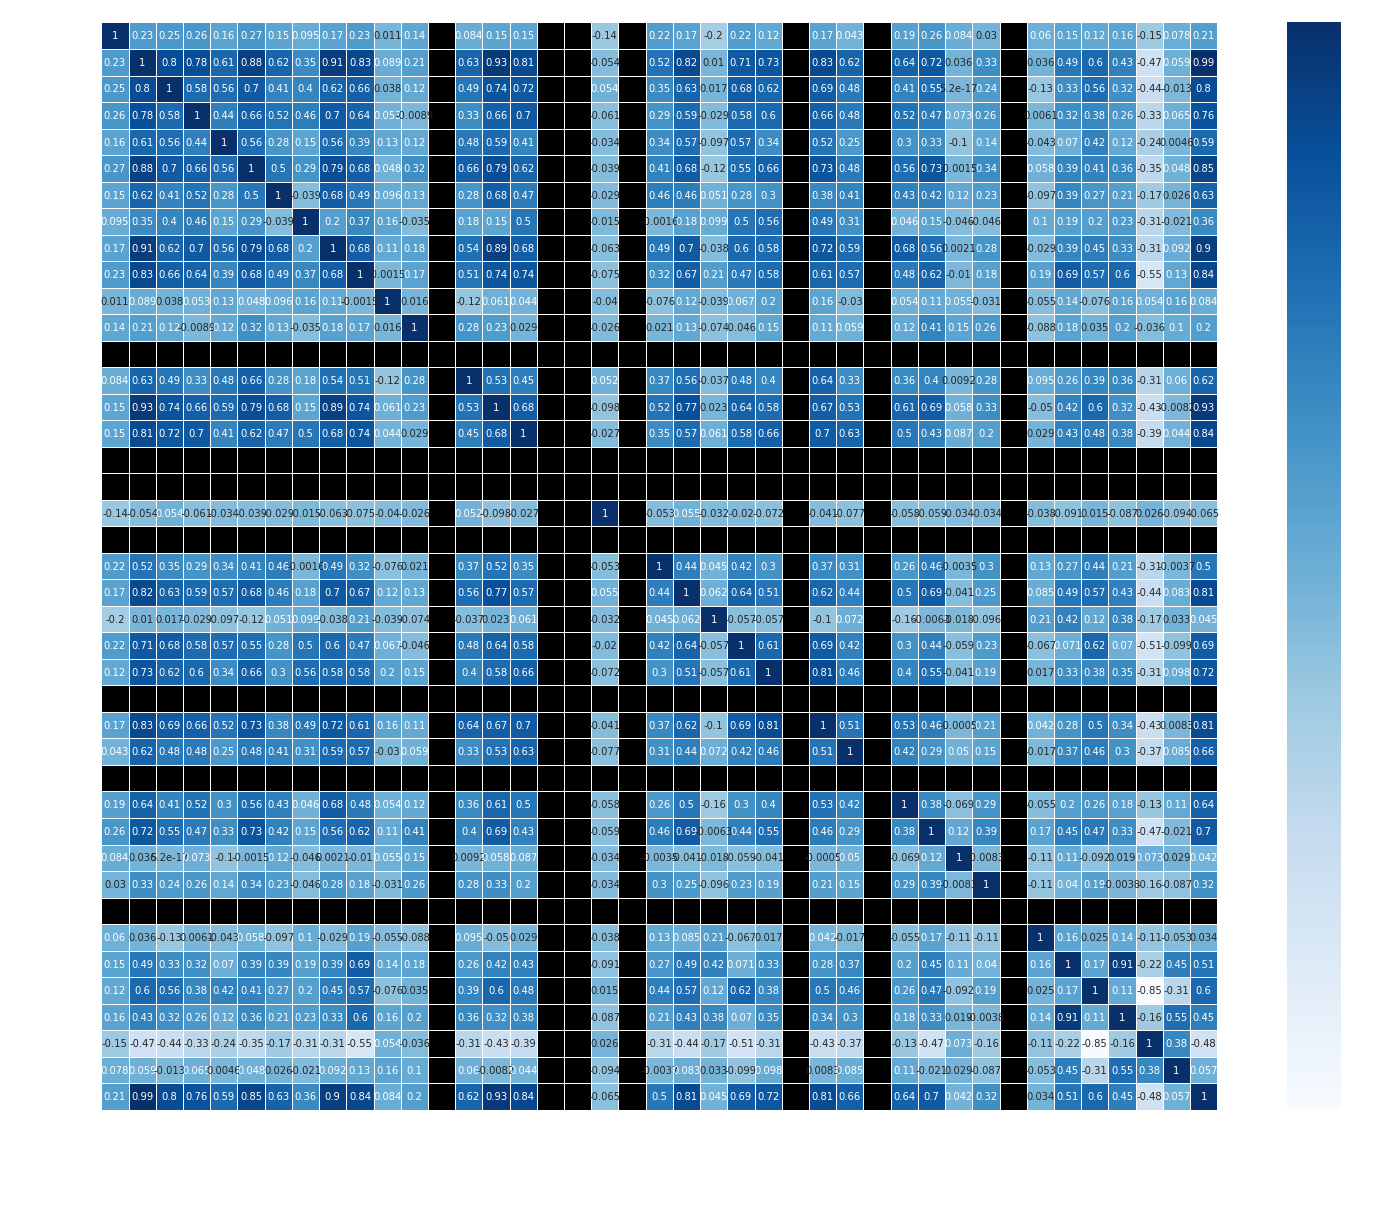

In [18]:
sum.get_heatmap()

In [19]:
sum.get_counter('sentiment')

{'Positive': 58, 'Negative': 30}

## Separación de datos de entrenamiento y prueba

In [20]:
X_train, X_test, y_train, y_test = split_dataset(df)

Dataset dividido.


## Ejecución de los algoritmos

### Nearest Neighbors


--------------------
Nearest Neighbors
--------------------
Modelo entrenado.
Predicción finalizada.
Accuracy calculado.
Confusion matrix:
 [[ 1  4]
 [ 4 18]]
Accuracy score: 0.7037037037037037
Classification report:
               precision    recall  f1-score   support

    Negative       0.20      0.20      0.20         5
    Positive       0.82      0.82      0.82        22

    accuracy                           0.70        27
   macro avg       0.51      0.51      0.51        27
weighted avg       0.70      0.70      0.70        27




/Users/porfirioads/.local/share/virtualenvs/tesis-sentiment-analysis-62Q1xMPT/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


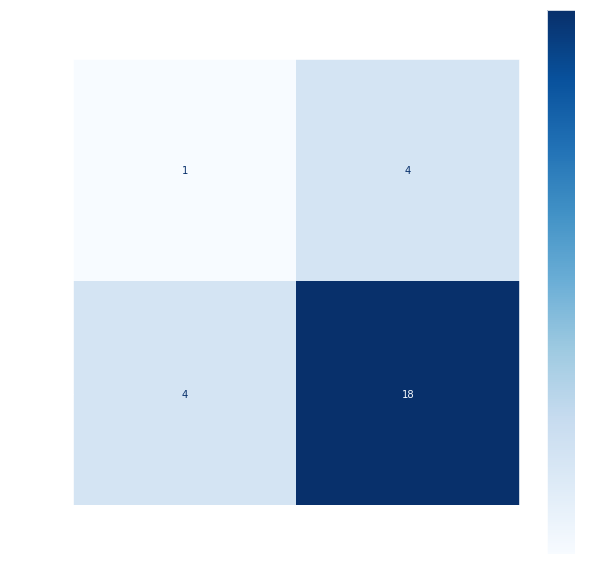

In [21]:
execute_algorithm(classifiers, 'Nearest Neighbors', X_train, X_test, y_train, y_test)

### Linear SVM


--------------------
Linear SVM
--------------------
Modelo entrenado.
Predicción finalizada.
Accuracy calculado.
Confusion matrix:
 [[ 1  4]
 [ 7 15]]
Accuracy score: 0.5925925925925926
Classification report:
               precision    recall  f1-score   support

    Negative       0.12      0.20      0.15         5
    Positive       0.79      0.68      0.73        22

    accuracy                           0.59        27
   macro avg       0.46      0.44      0.44        27
weighted avg       0.67      0.59      0.62        27




/Users/porfirioads/.local/share/virtualenvs/tesis-sentiment-analysis-62Q1xMPT/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


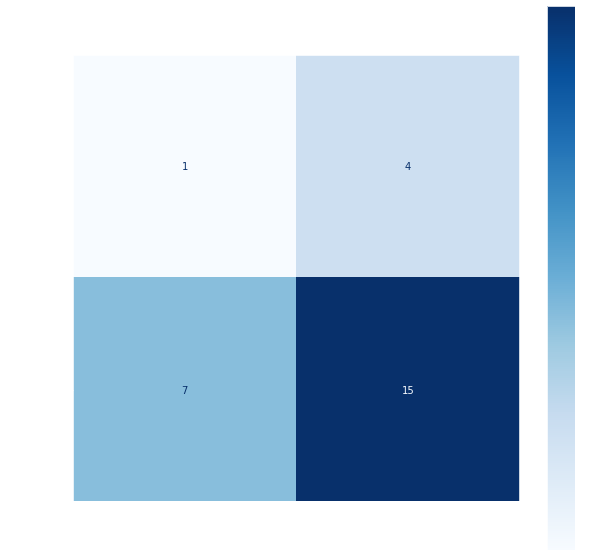

In [22]:
execute_algorithm(classifiers, 'Linear SVM', X_train, X_test, y_train, y_test)

### RBF SVM


--------------------
RBF SVM
--------------------
Modelo entrenado.
Predicción finalizada.
Accuracy calculado.
Confusion matrix:
 [[ 0  5]
 [ 0 22]]
Accuracy score: 0.8148148148148148
Classification report:
               precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         5
    Positive       0.81      1.00      0.90        22

    accuracy                           0.81        27
   macro avg       0.41      0.50      0.45        27
weighted avg       0.66      0.81      0.73        27




/Users/porfirioads/.local/share/virtualenvs/tesis-sentiment-analysis-62Q1xMPT/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/porfirioads/.local/share/virtualenvs/tesis-sentiment-analysis-62Q1xMPT/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/porfirioads/.local/share/virtualenvs/tesis-sentiment-analysis-62Q1xMPT/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with

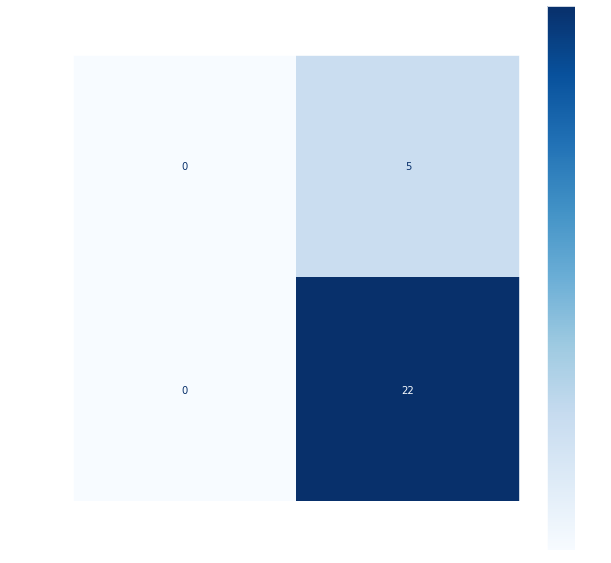

In [23]:
execute_algorithm(classifiers, 'RBF SVM', X_train, X_test, y_train, y_test)

### Gaussian Process


--------------------
Gaussian Process
--------------------
Modelo entrenado.
Predicción finalizada.
Accuracy calculado.
Confusion matrix:
 [[ 0  5]
 [ 6 16]]
Accuracy score: 0.5925925925925926
Classification report:
               precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         5
    Positive       0.76      0.73      0.74        22

    accuracy                           0.59        27
   macro avg       0.38      0.36      0.37        27
weighted avg       0.62      0.59      0.61        27




/Users/porfirioads/.local/share/virtualenvs/tesis-sentiment-analysis-62Q1xMPT/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


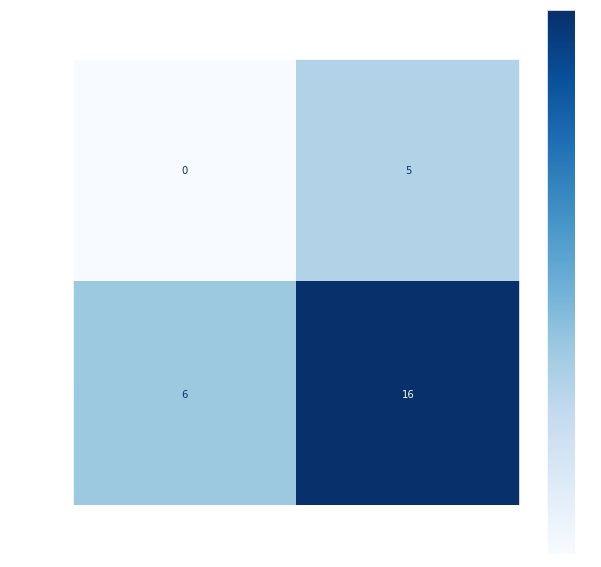

In [24]:
execute_algorithm(classifiers, 'Gaussian Process', X_train, X_test, y_train, y_test)

### Decision Tree


--------------------
Decision Tree
--------------------
Modelo entrenado.
Predicción finalizada.
Accuracy calculado.
Confusion matrix:
 [[ 1  4]
 [ 9 13]]
Accuracy score: 0.5185185185185185
Classification report:
               precision    recall  f1-score   support

    Negative       0.10      0.20      0.13         5
    Positive       0.76      0.59      0.67        22

    accuracy                           0.52        27
   macro avg       0.43      0.40      0.40        27
weighted avg       0.64      0.52      0.57        27




/Users/porfirioads/.local/share/virtualenvs/tesis-sentiment-analysis-62Q1xMPT/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


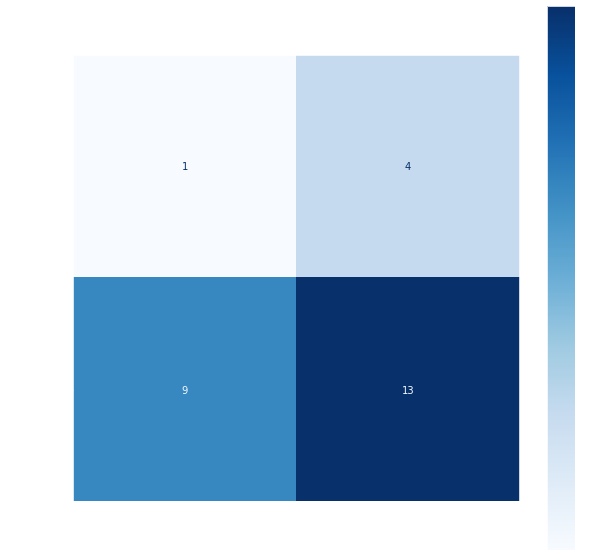

In [25]:
execute_algorithm(classifiers, 'Decision Tree', X_train, X_test, y_train, y_test)

### Random Forest


--------------------
Random Forest
--------------------
Modelo entrenado.
Predicción finalizada.
Accuracy calculado.
Confusion matrix:
 [[ 0  5]
 [ 5 17]]
Accuracy score: 0.6296296296296297
Classification report:
               precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         5
    Positive       0.77      0.77      0.77        22

    accuracy                           0.63        27
   macro avg       0.39      0.39      0.39        27
weighted avg       0.63      0.63      0.63        27




/Users/porfirioads/.local/share/virtualenvs/tesis-sentiment-analysis-62Q1xMPT/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


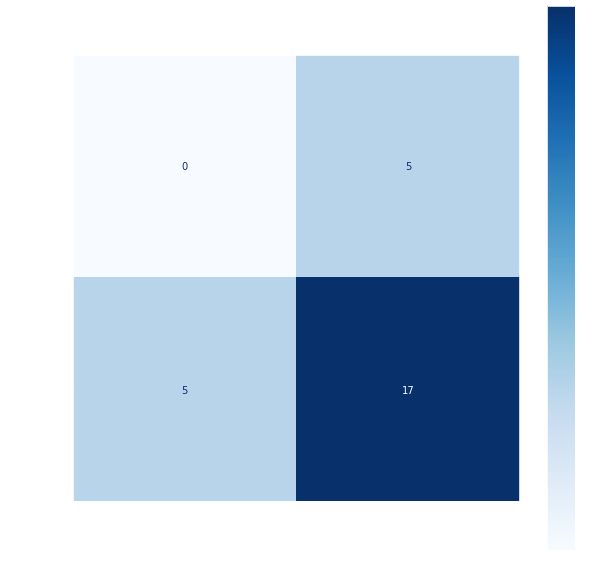

In [26]:
execute_algorithm(classifiers, 'Random Forest', X_train, X_test, y_train, y_test)

### Neural Net

/Users/porfirioads/.local/share/virtualenvs/tesis-sentiment-analysis-62Q1xMPT/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/porfirioads/.local/share/virtualenvs/tesis-sentiment-analysis-62Q1xMPT/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/porfirioads/.local/share/virtualenvs/tesis-sentiment-analysis-62Q1xMPT/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with


--------------------
Neural Net
--------------------
Modelo entrenado.
Predicción finalizada.
Accuracy calculado.
Confusion matrix:
 [[ 5  0]
 [22  0]]
Accuracy score: 0.18518518518518517
Classification report:
               precision    recall  f1-score   support

    Negative       0.19      1.00      0.31         5
    Positive       0.00      0.00      0.00        22

    accuracy                           0.19        27
   macro avg       0.09      0.50      0.16        27
weighted avg       0.03      0.19      0.06        27




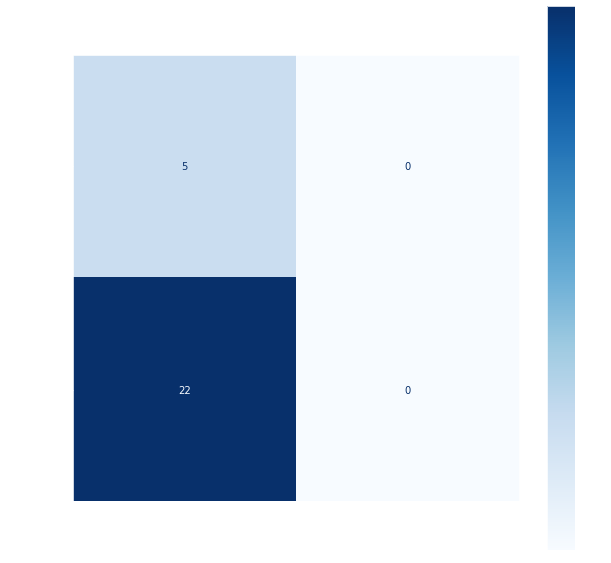

In [27]:
execute_algorithm(classifiers, 'Neural Net', X_train, X_test, y_train, y_test)

### AdaBoost


--------------------
AdaBoost
--------------------
Modelo entrenado.
Predicción finalizada.
Accuracy calculado.
Confusion matrix:
 [[ 1  4]
 [ 6 16]]
Accuracy score: 0.6296296296296297
Classification report:
               precision    recall  f1-score   support

    Negative       0.14      0.20      0.17         5
    Positive       0.80      0.73      0.76        22

    accuracy                           0.63        27
   macro avg       0.47      0.46      0.46        27
weighted avg       0.68      0.63      0.65        27




/Users/porfirioads/.local/share/virtualenvs/tesis-sentiment-analysis-62Q1xMPT/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


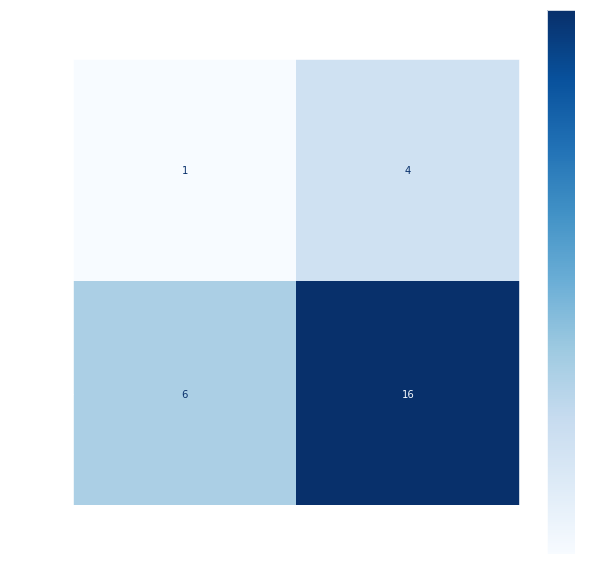

In [28]:
execute_algorithm(classifiers, 'AdaBoost', X_train, X_test, y_train, y_test)

### Naive Bayes


--------------------
Naive Bayes
--------------------
Modelo entrenado.
Predicción finalizada.
Accuracy calculado.
Confusion matrix:
 [[ 0  5]
 [ 6 16]]
Accuracy score: 0.5925925925925926
Classification report:
               precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         5
    Positive       0.76      0.73      0.74        22

    accuracy                           0.59        27
   macro avg       0.38      0.36      0.37        27
weighted avg       0.62      0.59      0.61        27




/Users/porfirioads/.local/share/virtualenvs/tesis-sentiment-analysis-62Q1xMPT/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


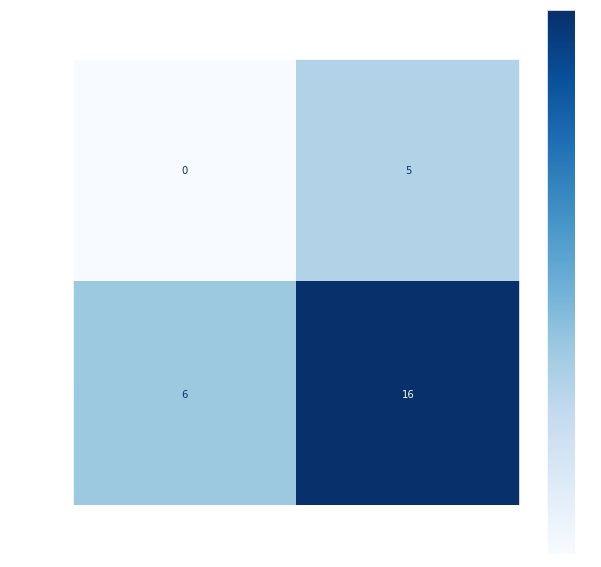

In [29]:
execute_algorithm(classifiers, 'Naive Bayes', X_train, X_test, y_train, y_test)

### Quadratic Discriminant


--------------------
QDA
--------------------


/Users/porfirioads/.local/share/virtualenvs/tesis-sentiment-analysis-62Q1xMPT/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/porfirioads/.local/share/virtualenvs/tesis-sentiment-analysis-62Q1xMPT/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/porfirioads/.local/share/virtualenvs/tesis-sentiment-analysis-62Q1xMPT/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/porfirioads/.

Modelo entrenado.
Predicción finalizada.
Accuracy calculado.
Confusion matrix:
 [[ 0  5]
 [ 0 22]]
Accuracy score: 0.8148148148148148
Classification report:
               precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         5
    Positive       0.81      1.00      0.90        22

    accuracy                           0.81        27
   macro avg       0.41      0.50      0.45        27
weighted avg       0.66      0.81      0.73        27




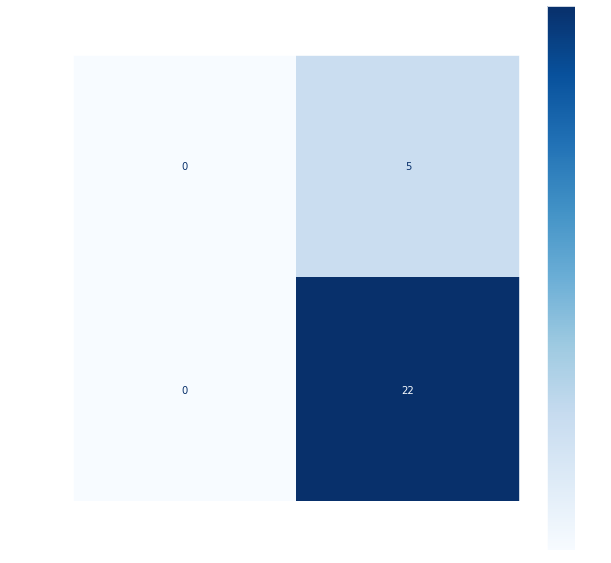

In [30]:
execute_algorithm(classifiers, 'QDA', X_train, X_test, y_train, y_test)

### Gradient Boosting


--------------------
Gradient Boosting
--------------------
Modelo entrenado.
Predicción finalizada.
Accuracy calculado.
Confusion matrix:
 [[ 0  5]
 [ 4 18]]
Accuracy score: 0.6666666666666666
Classification report:
               precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         5
    Positive       0.78      0.82      0.80        22

    accuracy                           0.67        27
   macro avg       0.39      0.41      0.40        27
weighted avg       0.64      0.67      0.65        27




/Users/porfirioads/.local/share/virtualenvs/tesis-sentiment-analysis-62Q1xMPT/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


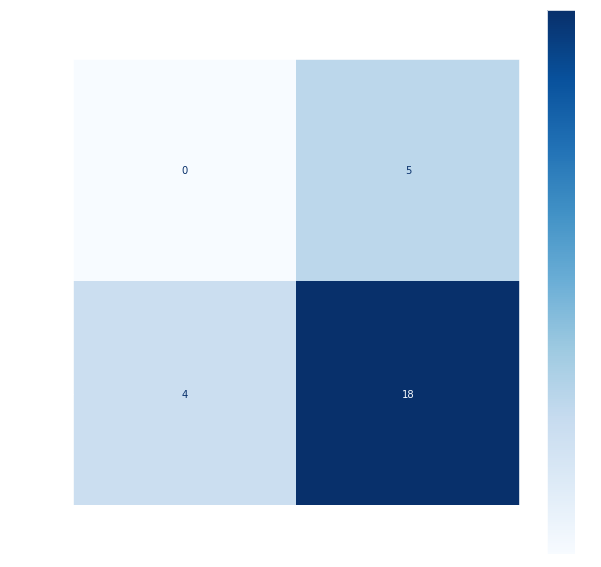

In [31]:
execute_algorithm(classifiers, 'Gradient Boosting', X_train, X_test, y_train, y_test)

### Logistic Regression


--------------------
Logistic Regression
--------------------
Modelo entrenado.
Predicción finalizada.
Accuracy calculado.
Confusion matrix:
 [[ 1  4]
 [ 6 16]]
Accuracy score: 0.6296296296296297
Classification report:
               precision    recall  f1-score   support

    Negative       0.14      0.20      0.17         5
    Positive       0.80      0.73      0.76        22

    accuracy                           0.63        27
   macro avg       0.47      0.46      0.46        27
weighted avg       0.68      0.63      0.65        27




/Users/porfirioads/.local/share/virtualenvs/tesis-sentiment-analysis-62Q1xMPT/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/porfirioads/.local/share/virtualenvs/tesis-sentiment-analysis-62Q1xMPT/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category

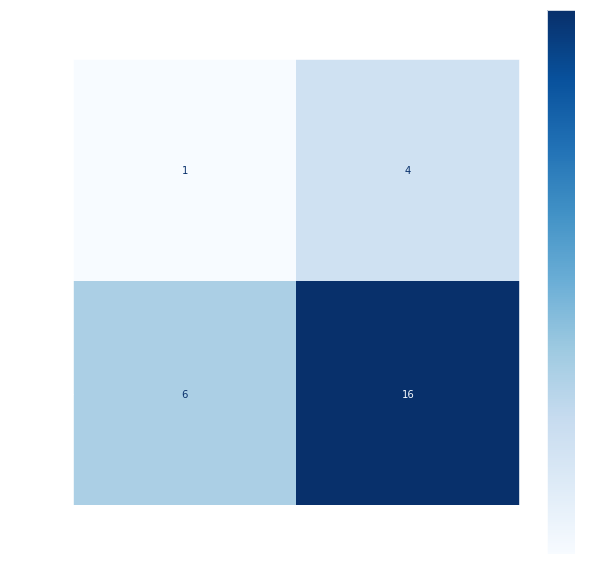

In [32]:
execute_algorithm(classifiers, 'Logistic Regression', X_train, X_test, y_train, y_test)

### Multinomial Naive Bayes

In [33]:
#execute_algorithm(classifiers, 'Multinomial Naive Bayes', X_train, X_test, y_train, y_test)

### Stochastic Gradient Descent


--------------------
Stochastic Gradient Descent
--------------------
Modelo entrenado.
Predicción finalizada.
Accuracy calculado.
Confusion matrix:
 [[ 0  5]
 [ 0 22]]
Accuracy score: 0.8148148148148148
Classification report:
               precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         5
    Positive       0.81      1.00      0.90        22

    accuracy                           0.81        27
   macro avg       0.41      0.50      0.45        27
weighted avg       0.66      0.81      0.73        27




/Users/porfirioads/.local/share/virtualenvs/tesis-sentiment-analysis-62Q1xMPT/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/porfirioads/.local/share/virtualenvs/tesis-sentiment-analysis-62Q1xMPT/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/porfirioads/.local/share/virtualenvs/tesis-sentiment-analysis-62Q1xMPT/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with

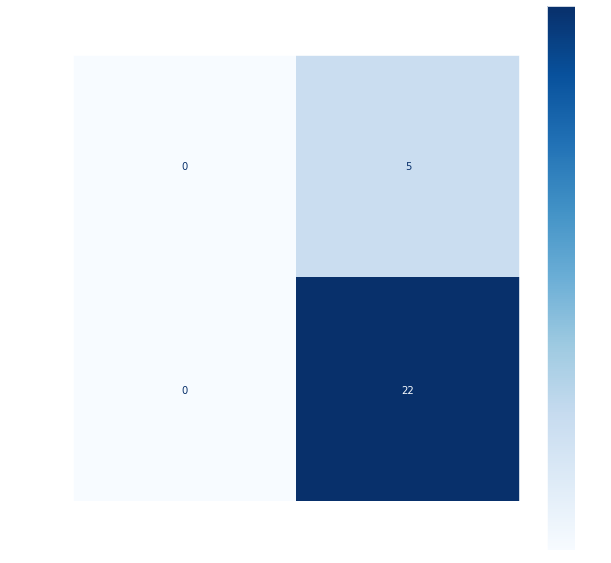

In [34]:
execute_algorithm(classifiers, 'Stochastic Gradient Descent', X_train, X_test, y_train, y_test)

### Oversampling y undersampling

In [35]:
for classifier in classifiers:
    print(f'\n--------------------\n{classifier}\n--------------------')
    print('>> under')
    under = sample(df, classifiers[classifier], True, False)
    print('>> over')
    over = sample(df, classifiers[classifier], False, True)
    print('>> under and over')
    both = sample(df, classifiers[classifier], True, True)



--------------------
Nearest Neighbors
--------------------
>> under
AUC: 0.6581944444444445
Accuracy: 0.6350694444444444
Recall: 0.6733333333333332
Precision: 0.7622619047619048
F1: 0.6350694444444444
>> over
AUC: 0.6116666666666667
Accuracy: 0.5982638888888888
Recall: 0.6175
Precision: 0.7362202380952381
F1: 0.5982638888888888
>> under and over
AUC: 0.6581944444444445
Accuracy: 0.6350694444444444
Recall: 0.6733333333333332
Precision: 0.7622619047619048
F1: 0.6350694444444444

--------------------
Linear SVM
--------------------
>> under
AUC: 0.7341666666666666
Accuracy: 0.6795138888888889
Recall: 0.705
Precision: 0.8026488095238096
F1: 0.6795138888888889
>> over
AUC: 0.7766666666666667
Accuracy: 0.6993055555555555
Recall: 0.7333333333333333
Precision: 0.8127678571428572
F1: 0.6993055555555555
>> under and over
AUC: 0.7341666666666666
Accuracy: 0.6795138888888889
Recall: 0.705
Precision: 0.8026488095238096
F1: 0.6795138888888889

--------------------
RBF SVM
--------------------
>> u

/Users/porfirioads/.local/share/virtualenvs/tesis-sentiment-analysis-62Q1xMPT/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/porfirioads/.local/share/virtualenvs/tesis-sentiment-analysis-62Q1xMPT/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/porfirioads/.local/share/virtualenvs/tesis-sentiment-analysis-62Q1xMPT/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control

AUC: 0.6558333333333334
Accuracy: 0.6909722222222221
Recall: 0.8100000000000002
Precision: 0.7478869047619048
F1: 0.6909722222222221
>> over
AUC: 0.5548611111111112
Accuracy: 0.6038194444444445
Recall: 0.6616666666666667
Precision: 0.7188690476190477
F1: 0.6038194444444445
>> under and over
AUC: 0.6558333333333334
Accuracy: 0.6909722222222221
Recall: 0.8100000000000002
Precision: 0.7478869047619048
F1: 0.6909722222222221

--------------------
Decision Tree
--------------------
>> under
AUC: 0.6534722222222222
Accuracy: 0.6416666666666666
Recall: 0.6808333333333334
Precision: 0.7751190476190476
F1: 0.6416666666666666
>> over
AUC: 0.5923611111111111
Accuracy: 0.5881944444444445
Recall: 0.6
Precision: 0.7395238095238096
F1: 0.5881944444444445
>> under and over
AUC: 0.6534722222222222
Accuracy: 0.6416666666666666
Recall: 0.6808333333333334
Precision: 0.7751190476190476
F1: 0.6416666666666666

--------------------
Random Forest
--------------------
>> under
AUC: 0.6511111111111111
Accuracy:

/Users/porfirioads/.local/share/virtualenvs/tesis-sentiment-analysis-62Q1xMPT/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC: 0.5930555555555556
Accuracy: 0.625
Recall: 0.755
Precision: 0.7075
F1: 0.625

--------------------
Neural Net
--------------------
>> under
AUC: 0.5677777777777779
Accuracy: 0.34444444444444444
Recall: 0.004166666666666667
Precision: 0.025
F1: 0.34444444444444444
>> over
AUC: 0.5658333333333334
Accuracy: 0.3416666666666666
Recall: 0.0
Precision: 0.0
F1: 0.3416666666666666
>> under and over
AUC: 0.5677777777777779
Accuracy: 0.34444444444444444
Recall: 0.004166666666666667
Precision: 0.025
F1: 0.34444444444444444

--------------------
AdaBoost
--------------------
>> under


/Users/porfirioads/.local/share/virtualenvs/tesis-sentiment-analysis-62Q1xMPT/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/porfirioads/.local/share/virtualenvs/tesis-sentiment-analysis-62Q1xMPT/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/porfirioads/.local/share/virtualenvs/tesis-sentiment-analysis-62Q1xMPT/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control

AUC: 0.6304166666666666
Accuracy: 0.6434027777777777
Recall: 0.7308333333333333
Precision: 0.7369940476190477
F1: 0.6434027777777777
>> over
AUC: 0.6300000000000001
Accuracy: 0.6055555555555555
Recall: 0.6258333333333332
Precision: 0.7652083333333334
F1: 0.6055555555555555
>> under and over
AUC: 0.6290277777777777
Accuracy: 0.6461805555555555
Recall: 0.735
Precision: 0.7381845238095238
F1: 0.6461805555555555

--------------------
Naive Bayes
--------------------
>> under
AUC: 0.5697222222222222
Accuracy: 0.6225694444444445
Recall: 0.7908333333333333
Precision: 0.6867857142857143
F1: 0.6225694444444445
>> over
AUC: 0.5634722222222223
Accuracy: 0.6472222222222221
Recall: 0.8283333333333335
Precision: 0.7007440476190476
F1: 0.6472222222222221
>> under and over
AUC: 0.5697222222222222
Accuracy: 0.6225694444444445
Recall: 0.7908333333333333
Precision: 0.6867857142857143
F1: 0.6225694444444445

--------------------
QDA
--------------------
>> under
AUC: 0.4291666666666667
Accuracy: 0.6274305

/Users/porfirioads/.local/share/virtualenvs/tesis-sentiment-analysis-62Q1xMPT/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/porfirioads/.local/share/virtualenvs/tesis-sentiment-analysis-62Q1xMPT/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/porfirioads/.local/share/virtualenvs/tesis-sentiment-analysis-62Q1xMPT/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/porfirioads/.local/share/virtualenvs/tesis-sentiment-analysis-62Q1xMPT/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/porfirioads/.local/share/virtualenvs/tesis-sentiment-analysis-62Q1xMPT/lib/python3.8/site-package

AUC: 0.725
Accuracy: 0.6930555555555555
Recall: 0.8008333333333333
Precision: 0.7612202380952382
F1: 0.6930555555555555
>> over
AUC: 0.6480555555555556
Accuracy: 0.5961805555555555
Recall: 0.615
Precision: 0.7440178571428572
F1: 0.5961805555555555
>> under and over
AUC: 0.7236111111111112
Accuracy: 0.6958333333333334
Recall: 0.8008333333333333
Precision: 0.7645535714285715
F1: 0.6958333333333334

--------------------
Logistic Regression
--------------------
>> under
AUC: 0.7691666666666667
Accuracy: 0.7027777777777777
Recall: 0.7266666666666667
Precision: 0.8145833333333334
F1: 0.7027777777777777
>> over
AUC: 0.7397222222222222
Accuracy: 0.6548611111111111
Recall: 0.6758333333333333
Precision: 0.7903869047619048
F1: 0.6548611111111111
>> under and over


/Users/porfirioads/.local/share/virtualenvs/tesis-sentiment-analysis-62Q1xMPT/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/porfirioads/.local/share/virtualenvs/tesis-sentiment-analysis-62Q1xMPT/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentati

AUC: 0.7763888888888889
Accuracy: 0.7
Recall: 0.7266666666666667
Precision: 0.811904761904762
F1: 0.7

--------------------
Stochastic Gradient Descent
--------------------
>> under
AUC: 0.6552777777777778
Accuracy: 0.5354166666666667
Recall: 0.5183333333333333
Precision: 0.5262202380952381
F1: 0.5354166666666667
>> over
AUC: 0.581388888888889
Accuracy: 0.4652777777777778
Recall: 0.3666666666666667
Precision: 0.2825
F1: 0.4652777777777778
>> under and over
AUC: 0.6230555555555556
Accuracy: 0.4725694444444445
Recall: 0.345
Precision: 0.346875
F1: 0.4725694444444445


/Users/porfirioads/.local/share/virtualenvs/tesis-sentiment-analysis-62Q1xMPT/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/porfirioads/.local/share/virtualenvs/tesis-sentiment-analysis-62Q1xMPT/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentati

---

In [38]:
list(classifiers.keys())

['Nearest Neighbors',
 'Linear SVM',
 'RBF SVM',
 'Gaussian Process',
 'Decision Tree',
 'Random Forest',
 'Neural Net',
 'AdaBoost',
 'Naive Bayes',
 'QDA',
 'Gradient Boosting',
 'Logistic Regression',
 'Stochastic Gradient Descent']

In [87]:
steps = [
    ('over', RandomOverSampler(random_state=random_state)),
    ('model', classifiers['Linear SVM']),
]

# ----
# def split_dataset(df: pd.DataFrame) -> tuple:
#     X = df.values[:, 3:]
#     y = df.values[:, 1]
#     X_train, X_test, y_train, y_test = model_selection.train_test_split(
#         X, y, test_size=0.3, random_state=100)
#     print('Dataset dividido.')
#     return X_train, X_test, y_train, y_test
# ----

X = df.values[:, 3:]
y = df.values[:, 1]

X_train, X_test, y_train, y_test = split_dataset(df)

pipe = Pipeline(steps)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X)

indexes = []

for i in range(len(X)):
    if y[i] != y_pred[i]:
        indexes.append(i)
        print(f'[{i}] y: {y[i]}, y_pred: {y_pred[i]}')

file = open('erroneas.csv', 'a', encoding='latin-1')

for index in indexes:
    row = df.iloc[index]
    file.write(f'{row["answer"]}\n')
    print(row["sentiment"])

file.close()


Dataset dividido.
[11] y: Negative, y_pred: Positive
[20] y: Positive, y_pred: Negative
[21] y: Negative, y_pred: Positive
[32] y: Negative, y_pred: Positive
[35] y: Positive, y_pred: Negative
[37] y: Positive, y_pred: Negative
[40] y: Negative, y_pred: Positive
[43] y: Negative, y_pred: Positive
[48] y: Negative, y_pred: Positive
[54] y: Positive, y_pred: Negative
[57] y: Negative, y_pred: Positive
[67] y: Negative, y_pred: Positive
[68] y: Positive, y_pred: Negative
[73] y: Positive, y_pred: Negative
[76] y: Positive, y_pred: Negative
[80] y: Positive, y_pred: Negative
[83] y: Positive, y_pred: Negative
[85] y: Positive, y_pred: Negative
[86] y: Positive, y_pred: Negative
[87] y: Positive, y_pred: Negative
Negative
Positive
Negative
Negative
Positive
Positive
Negative
Negative
Negative
Positive
Negative
Negative
Positive
Positive
Positive
Positive
Positive
Positive
Positive
Positive


# Métricas

**Accuracy:** In multilabel classification, this function computes subset accuracy: the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.

**Precision:** The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

**Recall:** The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

**F1:** The F1 score can be interpreted as a harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. 

**ROC:** Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.